# [Monte Carlo Vs Bootstrapping Time Series Data](https://pythonforfinance.net/2019/05/30/python-monte-carlo-vs-bootstrapping/)

## Import & settings

In [1]:
# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Center a matplotlib figure in a Jupyter notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import tqdm
import pandas as pd
import numpy as np
from functools import reduce
from statsmodels.stats import power as pwr
import yahoo_fin.stock_info as yf
import datetime
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

In [3]:
sns.set(font_scale=1.025, rc={'figure.figsize': (10, 6),
                              'axes.facecolor': '#f2f2f0',
                              'axes.edgecolor': '#f2f2f0',
                              'figure.facecolor': '#f2f2f0', 
                              'grid.color': '#c4c4c4', 
                              'grid.linewidth': 0.5,
                              'lines.linewidth': 1.5,
                              'text.color': '#000000',
                              'xtick.color': '#000000',
                              'ytick.color': '#000000'})

## Download Stock data 

In [4]:
start, end = datetime.datetime(2010, 10, 30), datetime.datetime(2021, 11, 17)
tickers = ['AAPL', 'INTC', 'MSFT', 'AMD', 'UNH', 'NEE', 'NKE', 'JPM', 'CMCSA', 'DIS', 'WMT', 'PG']

asset_universe = pd.DataFrame(
    [yf.get_data(ticker, start, end, '1d').loc[:, 'adjclose'] for ticker in tqdm.tqdm(tickers)], 
    index=tickers).T

asset_universe.info()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.48it/s]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2781 entries, 2010-11-01 to 2021-11-16
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2781 non-null   float64
 1   INTC    2781 non-null   float64
 2   MSFT    2781 non-null   float64
 3   AMD     2781 non-null   float64
 4   UNH     2781 non-null   float64
 5   NEE     2781 non-null   float64
 6   NKE     2781 non-null   float64
 7   JPM     2781 non-null   float64
 8   CMCSA   2781 non-null   float64
 9   DIS     2781 non-null   float64
 10  WMT     2781 non-null   float64
 11  PG      2781 non-null   float64
dtypes: float64(12)
memory usage: 347.0 KB


In [5]:
asset_universe.head(3)

,AAPL,INTC,MSFT,AMD,UNH,NEE,NKE,JPM,CMCSA,DIS,WMT,PG
2010-11-01,9.314047,14.688478,21.157892,7.36,30.503740,9.752327,17.781637,27.798996,8.349072,31.383198,41.905190,45.564289
2010-11-02,9.472658,14.524238,21.503319,7.54,31.255556,9.839144,17.924150,27.457275,8.422380,31.452875,42.275555,45.850761
2010-11-03,9.577994,14.738703,21.220692,7.64,30.968348,9.880741,17.941694,28.021872,8.418308,31.609671,42.368137,46.058464


In [6]:
asset_universe.tail(3)

,AAPL,INTC,MSFT,AMD,UNH,NEE,NKE,JPM,CMCSA,DIS,WMT,PG
2021-11-12,149.990005,50.310001,336.720001,147.889999,458.989990,86.309998,169.089996,166.860001,53.500000,159.630005,147.759995,146.559998
2021-11-15,150.000000,50.320000,336.070007,146.490005,450.799988,87.339996,168.850006,166.559998,53.380001,158.429993,146.910004,147.399994
2021-11-16,151.000000,50.610001,339.510010,152.449997,449.619995,86.980003,171.830002,165.360001,53.119999,158.830002,143.169998,147.190002


### EDA

#### Stock Universe

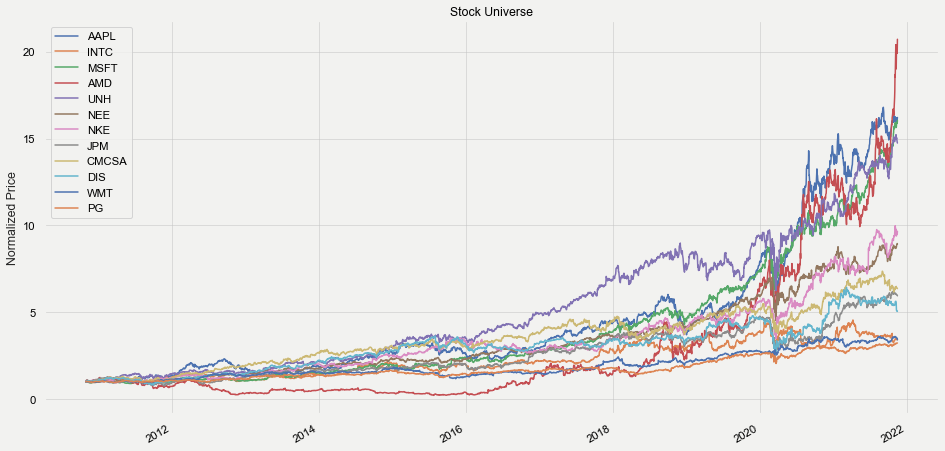

In [7]:
stock_universe = asset_universe / asset_universe.iloc[0, :]
stock_universe.plot(figsize=(16,8))
plt.ylabel('Normalized Price')
plt.title('Stock Universe');

#### Stock Universe Portfolio 

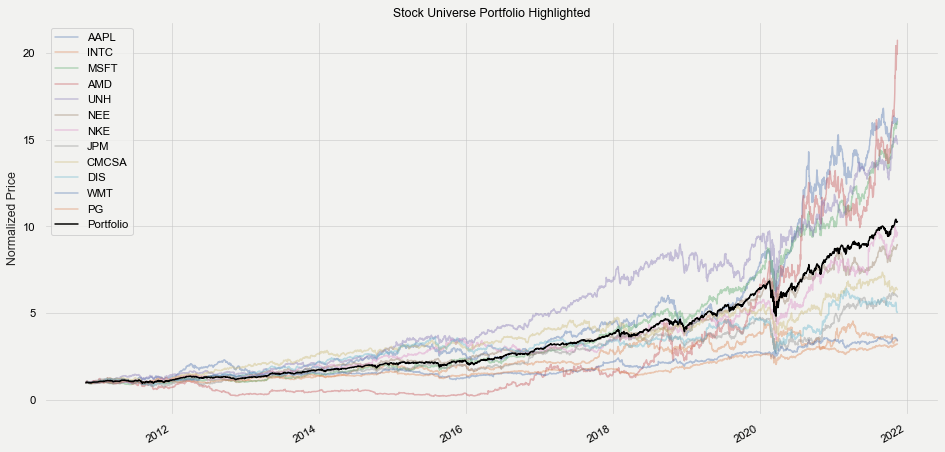

In [8]:
portfolio_returns = stock_universe.pct_change().dropna().mean(axis=1)
portfolio = (stock_universe.pct_change().dropna().mean(axis=1) + 1).cumprod()

stock_universe.plot(figsize=(16, 8), alpha=0.4)
portfolio.plot(label='Portfolio', color='black')
plt.ylabel('Normalized Price')
plt.title('Stock Universe Portfolio Highlighted');
plt.legend();

### Power Analysis for Sample Size Calculation

In [9]:
# Set parameters
effect = 0.1
power = 0.8
alpha = 0.05

# Calculate ratio
bin_portf_returns = np.where(stock_universe.pct_change().dropna().mean(axis=1) > 0, 1, 0)
pos_returns_count = float(len(bin_portf_returns[bin_portf_returns == 1]))
neg_returns_count = float(len(bin_portf_returns[bin_portf_returns == 0]))
ratio = pos_returns_count / neg_returns_count

# Initialize analysis and calculate sample size
analysis = pwr.TTestIndPower()
ss_result = int(analysis.solve_power(effect_size=effect, power=power, alpha=alpha, nobs1=None, ratio=ratio))

print(f'Sample Size: {ss_result}')

Sample Size: 1412


### Simulating Portfolio Returns using the $\mu$ of the sampled stock universe 

- **Population:**
    - Stock Universe Size: 12
    - DatetimeIndex: 2781 entries, 2010-11-01 to 2021-11-16


- **Sample:**
    - Sample Size: 1412
    - N Trails: 20,000

In [10]:
n_trails = 20_000
stock_universe_returns = stock_universe.pct_change()
portf_smps_df = pd.DataFrame()

for i in tqdm.tqdm(range(n_trails)):
    tmp_idx = stock_universe_returns.sample(n=ss_result, replace=True).index
    portf_smps_df[f'Trail_{i + 1}'] = (stock_universe_returns.loc[tmp_idx].mean(axis=1) + 1).cumprod().values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:35<00:00, 566.78it/s]


In [11]:
portf_smps_df.tail()

,Trail_1,Trail_2,Trail_3,Trail_4,Trail_5,Trail_6,Trail_7,Trail_8,Trail_9,Trail_10,...,Trail_19991,Trail_19992,Trail_19993,Trail_19994,Trail_19995,Trail_19996,Trail_19997,Trail_19998,Trail_19999,Trail_20000
1407,3.096718,4.142978,3.304072,5.203040,4.084496,2.803416,3.782542,1.825293,2.226456,4.090769,...,2.431272,2.171303,5.604558,1.599792,2.889541,2.968797,3.342141,2.656500,3.718311,3.532989
1408,3.083978,4.152127,3.306343,5.177962,4.074280,2.781544,3.766064,1.819727,2.224263,4.116874,...,2.500838,2.168953,5.639388,1.605029,2.906383,2.986356,3.357947,2.599820,3.744924,3.538484
1409,3.092511,4.154677,3.327011,5.256729,4.077317,2.775180,3.749385,1.827957,2.158295,4.129617,...,2.523446,2.176787,5.664587,1.576849,2.868328,2.961540,3.363520,2.607106,3.751419,3.509990
1410,3.108418,4.188285,3.331853,5.255256,4.140210,2.786386,3.747985,1.841354,2.149212,4.173174,...,2.485949,2.185651,5.766077,1.573437,2.864349,2.940180,3.388169,2.583341,3.767306,3.517741
1411,3.152762,4.207811,3.229536,5.222984,4.161252,2.803284,3.656549,1.847603,2.158464,4.178828,...,2.500630,2.175596,5.776925,1.588430,2.874178,2.876228,3.391280,2.596180,3.794799,3.514061


#### Plot of each simulated 1yr portfolio return

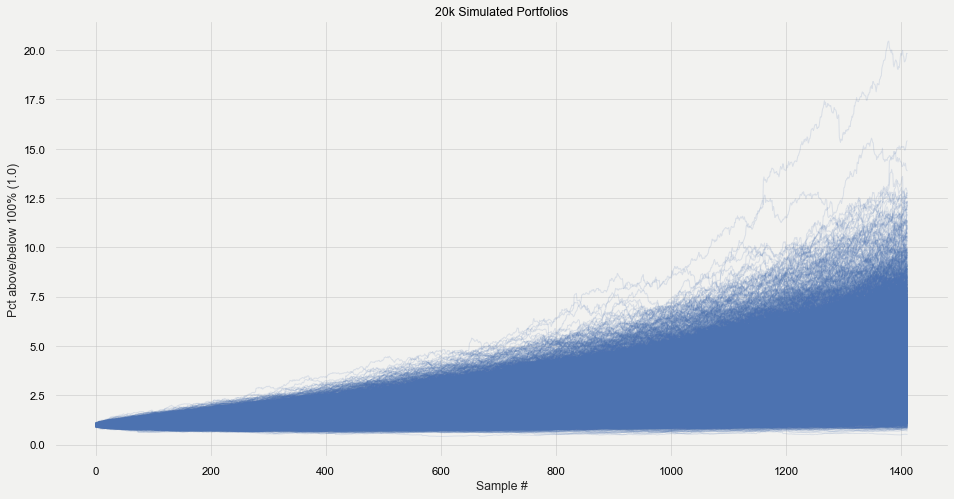

In [12]:
portf_smps_df.plot(figsize=(16,8), legend=False, lw=1, alpha=0.15, color='b')
plt.ylabel('Pct above/below 100% (1.0)')
plt.xlabel('Sample #')
plt.title('20k Simulated Portfolios');

#### Plot of each simulated 1yr portfolio return distribution 

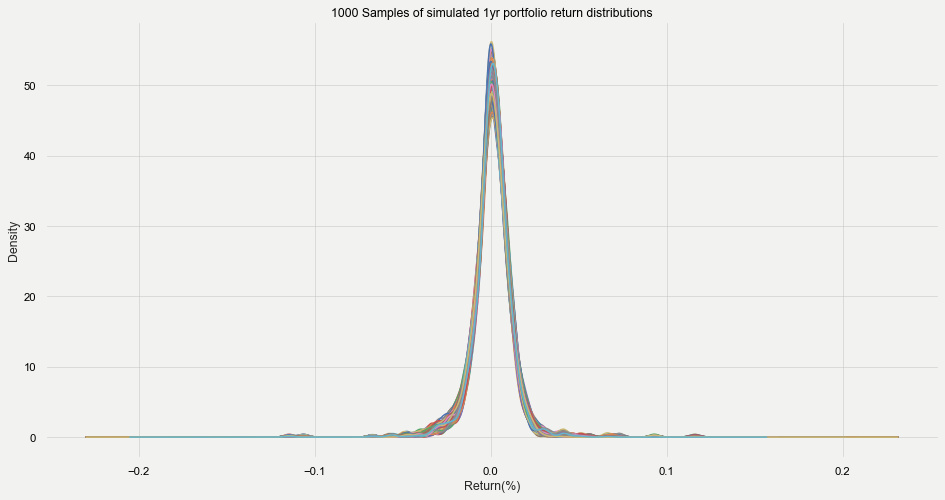

In [13]:
plt_samp_size = 1000
samp_cols = np.random.choice(portf_smps_df.columns, size=plt_samp_size, replace=False)
portf_smps_df[samp_cols].pct_change().dropna().plot(kind='kde', figsize=(16,8), legend=False)
plt.xlabel('Return(%)')
plt.title(f'{plt_samp_size} Samples of simulated 1yr portfolio return distributions');

#### Statistical Distribution Comparison Distribution Plot

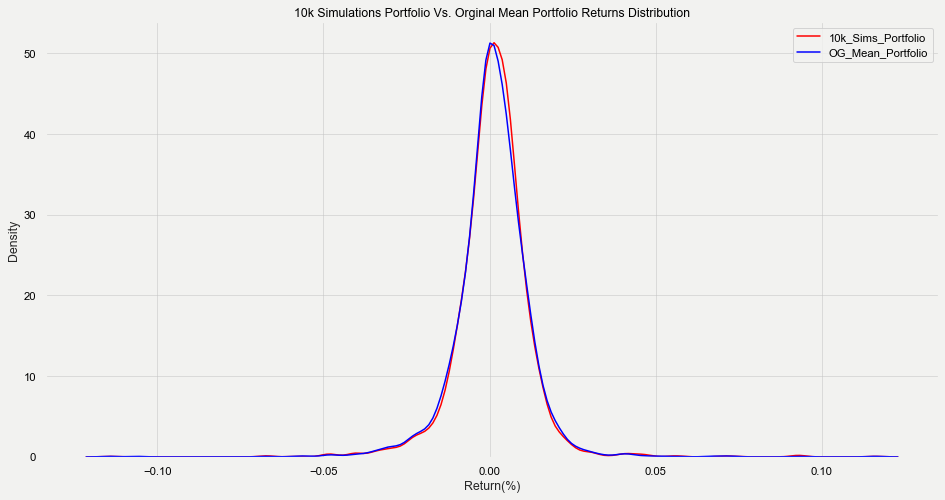

In [14]:
_10k_Sims_Portfolio = portf_smps_df.pct_change().dropna().stack()
_10k_Sims_Portfolio_Samp = _10k_Sims_Portfolio.sample(n=len(stock_universe_returns) - 1, replace=True)

plt.figure(figsize=(16,8))
sns.kdeplot(_10k_Sims_Portfolio_Samp.values, color='red');
sns.kdeplot(portfolio_returns, color='blue')
plt.xlabel('Return(%)')
plt.title('10k Simulations Portfolio Vs. Orginal Mean Portfolio Returns Distribution')
plt.legend(['10k_Sims_Portfolio', 'OG_Mean_Portfolio']);

#### Time Series Plot

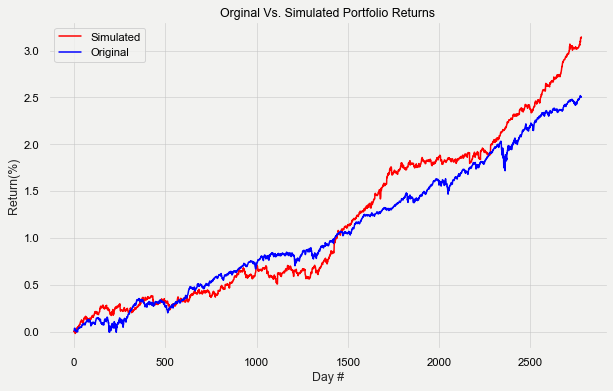

In [15]:
_10k_Sims_Portfolio_Samp.reset_index(drop=True).cumsum().plot(color='red', label='Simulated')
portfolio_returns.reset_index(drop=True).cumsum().plot(color='blue', label='Original')
plt.xlabel('Day #')
plt.ylabel('Return(%)')
plt.title('Orginal Vs. Simulated Portfolio Returns')
plt.legend();

#### Statistical Distribution Comparison

In [16]:
pd.concat([
    _10k_Sims_Portfolio.describe().to_frame().T.round(7).rename(index={0: '10k_Sims_Portfolio'}),
    _10k_Sims_Portfolio_Samp.describe().to_frame().T.round(7).rename(index={0: '10k_Sims_Portfolio_Samp'}),
    portfolio_returns.describe().to_frame().T.round(7).rename(index={0: 'OG_Mu_Portfolio'})
], axis=0)

,count,mean,std,min,25%,50%,75%,max
10k_Sims_Portfolio,28200000.0,0.000901,0.011186,-0.114549,-0.003915,0.001048,0.006262,0.115998
10k_Sims_Portfolio_Samp,2780.0,0.001131,0.011159,-0.114549,-0.003609,0.001395,0.006219,0.115998
OG_Mu_Portfolio,2780.0,0.000901,0.011194,-0.114549,-0.003916,0.001049,0.006265,0.115998


#### Kolmogorov-Smirnov Test

The two sample Kolmogorov-Smirnov test is a nonparametric test that compares the cumulative distributions of two data sets. The test is nonparametric. It does not assume that data are sampled from Gaussian distributions (or any other defined distributions).

- The null hypothesis is that both groups were sampled from populations with identical distributions. It tests for any violation of that null hypothesis -- different medians, different variances, or different distributions.
- If the p-value is lower than $\alpha$, then it is very probable that the two distributions are different.

In [17]:
stat, p_val = stats.kstest(_10k_Sims_Portfolio_Samp, portfolio_returns)

alpha = 0.05

print(f'- Level of significance: {alpha}')
print(f'\n- P-Value: {round(p_val,5)}')

if p_val < alpha: 
    print('\n- We have evidence to reject the null hypothesis that both groups were sampled from populations with identical distributions')
else:
    print('\n- We have no evidence to reject the null hypothesis that both groups were sampled from populations with identical distributions') 

- Level of significance: 0.05

- P-Value: 0.47318

- We have no evidence to reject the null hypothesis that both groups were sampled from populations with identical distributions


In [23]:
p_vals = []; sim_samps = pd.DataFrame()
for i in tqdm.tqdm(range(10_000)):
    _Sim_Portf = _10k_Sims_Portfolio.sample(n=len(stock_universe_returns) - 1, replace=True)
    sim_samps[f'Trial_{i + 1}'] = _Sim_Portf.values
    _, p_val = stats.kstest(_Sim_Portf, portfolio_returns)
    p_vals.append(p_val)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.95it/s]


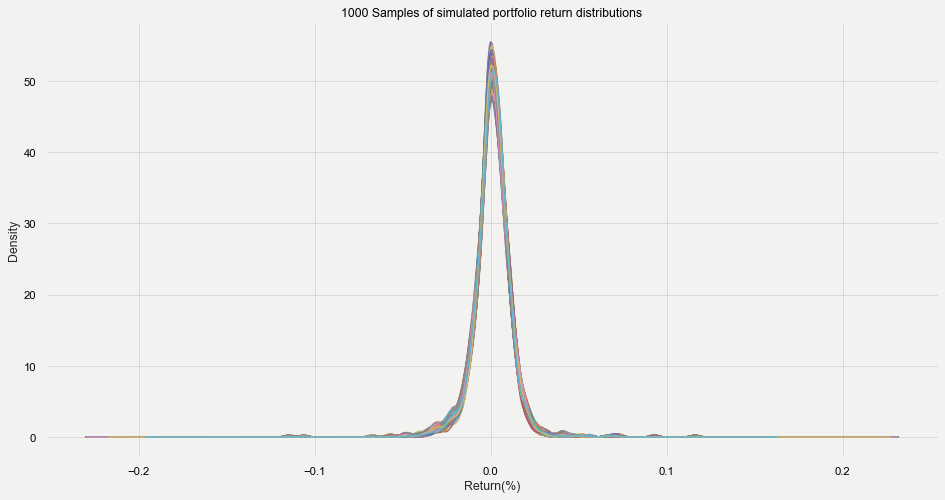

In [19]:
samp_cols = np.random.choice(sim_samps.columns, size=plt_samp_size, replace=False)
sim_samps[samp_cols].plot(kind='kde', figsize=(16,8), legend=False, alpha=0.5)
plt.xlabel('Return(%)')
plt.title(f'{plt_samp_size} Samples of simulated portfolio return distributions');

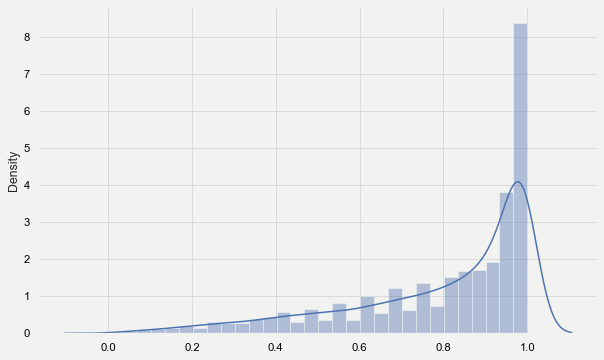

In [52]:
sns.distplot(p_vals, norm_hist=True, bins=30);